## Image feature extraction

In [2]:

from dgl.nn import SAGEConv
import dgl.function as fn
from umap.umap_ import UMAP
from sklearn.metrics import roc_auc_score
import dgl
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import json
import gzip
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import dgl.data
import os
import random
import datetime
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from mlflow import log_metric, log_param, log_artifact
import mlflow.sklearn
import mlflow.xgboost


from mlflow.tracking import MlflowClient


In [4]:
remote_server_uri = "http://127.0.0.1:5000/"  # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
experiment_name = 'Men_Clothing_Image_recommendation_v3'

mlflow.set_experiment(experiment_name)
# Forcing an end_run() to prevent 
#    https://github.com/mlflow/mlflow/issues/1335 
#    https://github.com/mlflow/mlflow/issues/608

mlflow.autolog()

artifact_path = mlflow.get_artifact_uri()
uri = mlflow.tracking.get_tracking_uri()
print(artifact_path)
print(uri)
mlflow.end_run()

2025/02/22 12:25:14 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/02/22 12:25:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/02/22 12:25:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/02/22 12:25:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/02/22 12:25:15 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This ini

mlflow-artifacts:/473744221893913913/49d9fbce333e4b54abbe1066ee45aa69/artifacts
http://127.0.0.1:5000/


In [5]:
from mlflow.tracking import MlflowClient
client = MlflowClient(mlflow.get_tracking_uri())


In [6]:
IMAGE_MODEL = 'inception'

In [7]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

cuda
Num GPUs Available:  1


In [8]:
nodes = pd.read_parquet(f'../Dataset/nodes_without_image.parquet',engine='pyarrow')
edges = pd.read_parquet(f'../Dataset/edges_without_image.parquet',engine='pyarrow')

In [9]:
print("Node data shape :",nodes.shape)
print("Edges data shape :",edges.shape)
# print("Size of Input features :",len(cols_needed))
# print("node features shape :",node_features.shape)
# node_labels = torch.from_numpy(text_df['niche'].astype('category').cat.codes.to_numpy())
edges_src = torch.from_numpy(edges['asin'].to_numpy())
edges_dst = torch.from_numpy(edges['also_buy'].to_numpy())

Node data shape : (10867, 40)
Edges data shape : (20554, 2)


In [10]:
cols_needed = list(nodes.drop(columns=['asin','also_buy']).columns)

In [11]:
from util import *

In [12]:
IMAGE_MODEL = 'inception'
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_no_features',
                                                                                                                                          n_epochs=100,
                                                                                                                                          image_included=False,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3},patience=100,only_image=False,skip_ndata=True,use_bidirectional=True)

skipping adding node features
Node data shape : (10867, 39)
Edges data shape : (20554, 2)
Size of Input features : 0
node features shape : torch.Size([10867, 39])
##########################
Converting to biderctional Graph
##########################
27998 11999
In epoch 0, loss: 27.480663299560547
Epoch 0: Best model saved min loss 27.480663299560547
Epoch 1: Best model saved min loss 8.636537551879883
Epoch 2: Best model saved min loss 4.44978666305542
Epoch 3: Best model saved min loss 2.210573673248291
Epoch 4: Best model saved min loss 0.9635067582130432
In epoch 5, loss: 0.6672428250312805
Epoch 5: Best model saved min loss 0.6672428250312805
Epoch 6: Best model saved min loss 0.571540892124176
Epoch 7: Best model saved min loss 0.5396424531936646
Epoch 8: Best model saved min loss 0.5073716044425964
Epoch 9: Best model saved min loss 0.46218207478523254
In epoch 10, loss: 0.429837167263031
Epoch 10: Best model saved min loss 0.429837167263031
Epoch 11: Best model saved min loss 0

100%|██████████| 10867/10867 [00:01<00:00, 6332.62it/s]


Train recall@100 0.6104862324571897
Test recall@100 0.5978765462443362


In [16]:
IMAGE_MODEL = 'inception'
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_only_image',
                                                                                                                                          n_epochs=100,
                                                                                                                                          image_included=True,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3},patience=100,only_image=True,skip_ndata=True,use_bidirectional=True)

c:\Users\Kartik\anaconda3\envs\tf\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Node data shape : (10867, 139)
Edges data shape : (20554, 2)
Size of Input features : 100
node features shape : torch.Size([10867, 100])
##########################
Converting to biderctional Graph
##########################
27998 11999
In epoch 0, loss: 374.6854553222656
Epoch 0: Best model saved min loss 374.6854553222656
Epoch 1: Best model saved min loss 45.380401611328125
Epoch 2: Best model saved min loss 1.8589144945144653
Epoch 3: Best model saved min loss 0.5453778505325317
Epoch 4: Best model saved min loss 0.4686381220817566
In epoch 5, loss: 0.42239633202552795
Epoch 5: Best model saved min loss 0.42239633202552795
Epoch 6: Best model saved min loss 0.38825875520706177
Epoch 7: Best model saved min loss 0.38209158182144165
In epoch 10, loss: 0.41835013031959534
Epoch 13: Best model saved min loss 0.3803039491176605
Epoch 14: Best model saved min loss 0.3647315800189972
In epoch 15, loss: 0.35424262285232544
Epoch 15: Best model saved min loss 0.35424262285232544
Epoch 16: Be

100%|██████████| 10867/10867 [00:01<00:00, 6503.07it/s]


Train recall@100 0.6104862324571897
Test recall@100 0.5978765462443362


In [26]:
all_nodes_cols = list(nodes.columns.values)

In [ ]:
node

In [28]:
all_nodes_cols = [
 'price_power_transform',
 'avg_rating',
 'no_of_ratings',
 'rank_num_power_transform',
 'label_1',
 'label_2',
 'label_3',
 'label_4',
 'label_5',
 'label_6',
 'label_7',
 'label_8',
 'label_9',
 'label_10',
 'label_11',
 'label_12',
 'label_13',
 'cluster_group_cluster 0',
 'cluster_group_cluster 1',
 'cluster_group_cluster 2',
 'cluster_group_cluster 3',
 'cluster_group_cluster 4',
 'cluster_group_cluster 5',
 'cluster_group_cluster 6',
 'cluster_group_cluster 7',
 'cluster_group_cluster 8',
 'cluster_group_cluster 9',
 'clothing_type_Active',
 'clothing_type_Jackets & Coats',
 'clothing_type_Jeans',
 'clothing_type_Pants',
 'clothing_type_Shirts',
 'clothing_type_Shorts',
 'clothing_type_Sleep & Lounge',
 'clothing_type_Socks',
 'clothing_type_Swim',
 'clothing_type_Underwear']

only_text = ['cluster_group_cluster 0',
 'cluster_group_cluster 1',
 'cluster_group_cluster 2',
 'cluster_group_cluster 3',
 'cluster_group_cluster 4',
 'cluster_group_cluster 5',
 'cluster_group_cluster 6',
 'cluster_group_cluster 7',
 'cluster_group_cluster 8',
 'cluster_group_cluster 9',]

only_product_data = [
 'price_power_transform',
 'avg_rating',
 'no_of_ratings',
 'rank_num_power_transform',
 'label_1',
 'label_2',
 'label_3',
 'label_4',
 'label_5',
 'label_6',
 'label_7',
 'label_8',
 'label_9',
 'label_10',
 'label_11',
 'label_12',
 'label_13',
 'clothing_type_Active',
 'clothing_type_Jackets & Coats',
 'clothing_type_Jeans',
 'clothing_type_Pants',
 'clothing_type_Shirts',
 'clothing_type_Shorts',
 'clothing_type_Sleep & Lounge',
 'clothing_type_Socks',
 'clothing_type_Swim',
 'clothing_type_Underwear']

In [ ]:
# nodes_new = nodes.copy()
# nodes_new['temp'] = 0

In [12]:
IMAGE_MODEL = 'inception'
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_no_data_actual',
                                                                                                                                          n_epochs=100,
                                                                                                                                          image_included=False,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3},patience=100,only_image=False,skip_ndata=False,use_bidirectional=True,cols_needed=['no_data'])

Node data shape : (10867, 40)
Edges data shape : (20554, 2)
Size of Input features : 1
node features shape : torch.Size([10867, 1])
##########################
Converting to biderctional Graph
##########################
27998 11999
In epoch 0, loss: 1.8259583711624146
Epoch 0: Best model saved min loss 1.8259583711624146
Epoch 1: Best model saved min loss 1.126548171043396
Epoch 2: Best model saved min loss 0.7936579585075378
Epoch 3: Best model saved min loss 0.6106050610542297
Epoch 4: Best model saved min loss 0.5968731045722961
In epoch 5, loss: 0.5507875084877014
Epoch 5: Best model saved min loss 0.5507875084877014
Epoch 6: Best model saved min loss 0.49040740728378296
Epoch 7: Best model saved min loss 0.47377192974090576
Epoch 8: Best model saved min loss 0.4505481421947479
Epoch 9: Best model saved min loss 0.4395662546157837
In epoch 10, loss: 0.4191192090511322
Epoch 10: Best model saved min loss 0.4191192090511322
Epoch 11: Best model saved min loss 0.41060760617256165
Epoch

100%|██████████| 10867/10867 [00:01<00:00, 7756.56it/s]


Train recall@100 0.6104862324571897
Test recall@100 0.5980210086089479


In [ ]:
IMAGE_MODEL = 'inception'
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_no_data_actual',
                                                                                                                                          n_epochs=100,
                                                                                                                                          image_included=False,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3},patience=100,only_image=False,skip_ndata=True,use_bidirectional=True,cols_needed=[])

skipping adding node features
Node data shape : (10867, 39)
Edges data shape : (20554, 2)
Size of Input features : 0
node features shape : torch.Size([10867, 39])
##########################
Converting to biderctional Graph
##########################
27998 11999
In epoch 0, loss: 27.480663299560547
Epoch 0: Best model saved min loss 27.480663299560547
Epoch 1: Best model saved min loss 8.636537551879883
Epoch 2: Best model saved min loss 4.44978666305542
Epoch 3: Best model saved min loss 2.210573673248291
Epoch 4: Best model saved min loss 0.9635067582130432
In epoch 5, loss: 0.6672428250312805
Epoch 5: Best model saved min loss 0.6672428250312805
Epoch 6: Best model saved min loss 0.571540892124176
Epoch 7: Best model saved min loss 0.5396424531936646
Epoch 8: Best model saved min loss 0.5073716044425964
Epoch 9: Best model saved min loss 0.46218207478523254
In epoch 10, loss: 0.4298371374607086
Epoch 10: Best model saved min loss 0.4298371374607086
Epoch 11: Best model saved min loss

100%|██████████| 10867/10867 [00:12<00:00, 850.31it/s]


Train recall@100 0.6104862324571897
Test recall@100 0.5978765462443362


In [31]:
IMAGE_MODEL = 'inception'
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_only_product+text_metadata',
                                                                                                                                          n_epochs=100,
                                                                                                                                          image_included=False,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3},patience=100,only_image=False,skip_ndata=False,use_bidirectional=True,cols_needed=only_product_data+only_text)

Node data shape : (10867, 39)
Edges data shape : (20554, 2)
Size of Input features : 37
node features shape : torch.Size([10867, 37])
##########################
Converting to biderctional Graph
##########################
27998 11999
In epoch 0, loss: 5483.46240234375
Epoch 0: Best model saved min loss 5483.46240234375
Epoch 1: Best model saved min loss 5445.2421875
Epoch 2: Best model saved min loss 3668.992919921875
Epoch 3: Best model saved min loss 2709.804931640625
Epoch 4: Best model saved min loss 2200.12646484375
In epoch 5, loss: 7776.74609375
Epoch 7: Best model saved min loss 1172.1524658203125
Epoch 9: Best model saved min loss 1013.9771118164062
In epoch 10, loss: 1486.98388671875
Epoch 12: Best model saved min loss 822.5794677734375
In epoch 15, loss: 1935.3697509765625
Epoch 16: Best model saved min loss 286.2039794921875
Epoch 17: Best model saved min loss 271.3336486816406
Epoch 18: Best model saved min loss 211.3053436279297
In epoch 20, loss: 336.4604797363281
Epoch 2

100%|██████████| 10867/10867 [00:01<00:00, 6215.94it/s]


Train recall@100 0.6104862324571897
Test recall@100 0.5978765462443362


In [32]:
IMAGE_MODEL = 'inception'
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_only_product_metadata',
                                                                                                                                          n_epochs=100,
                                                                                                                                          image_included=False,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3},patience=100,only_image=False,skip_ndata=False,use_bidirectional=True,cols_needed=only_product_data)

Node data shape : (10867, 39)
Edges data shape : (20554, 2)
Size of Input features : 27
node features shape : torch.Size([10867, 27])
##########################
Converting to biderctional Graph
##########################
27998 11999
In epoch 0, loss: 5387.38134765625
Epoch 0: Best model saved min loss 5387.38134765625
Epoch 1: Best model saved min loss 3287.942138671875
Epoch 4: Best model saved min loss 2835.164794921875
In epoch 5, loss: 5583.015625
Epoch 7: Best model saved min loss 2052.161865234375
Epoch 8: Best model saved min loss 1329.1650390625
In epoch 10, loss: 944.9027709960938
Epoch 10: Best model saved min loss 944.9027709960938
Epoch 11: Best model saved min loss 588.4091796875
Epoch 12: Best model saved min loss 488.39837646484375
Epoch 13: Best model saved min loss 364.8069763183594
In epoch 15, loss: 1105.9344482421875
Epoch 16: Best model saved min loss 290.2758483886719
Epoch 17: Best model saved min loss 201.22207641601562
Epoch 19: Best model saved min loss 156.33

100%|██████████| 10867/10867 [00:01<00:00, 6962.82it/s]


Train recall@100 0.40168960175532337
Test recall@100 0.41524177109963795


In [33]:
IMAGE_MODEL = 'inception'
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_only_text_data',
                                                                                                                                          n_epochs=100,
                                                                                                                                          image_included=False,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3},patience=100,only_image=False,skip_ndata=False,use_bidirectional=True,cols_needed=only_text)

Node data shape : (10867, 39)
Edges data shape : (20554, 2)
Size of Input features : 10
node features shape : torch.Size([10867, 10])
##########################
Converting to biderctional Graph
##########################
27998 11999
In epoch 0, loss: 0.7939828634262085
Epoch 0: Best model saved min loss 0.7939828634262085
Epoch 1: Best model saved min loss 0.6304920315742493
Epoch 2: Best model saved min loss 0.5162049531936646
Epoch 3: Best model saved min loss 0.4277537167072296
Epoch 4: Best model saved min loss 0.36588162183761597
In epoch 5, loss: 0.3391372263431549
Epoch 5: Best model saved min loss 0.3391372263431549
Epoch 6: Best model saved min loss 0.33505338430404663
Epoch 7: Best model saved min loss 0.32757723331451416
Epoch 8: Best model saved min loss 0.31571924686431885
Epoch 9: Best model saved min loss 0.3055313527584076
In epoch 10, loss: 0.29426226019859314
Epoch 10: Best model saved min loss 0.29426226019859314
Epoch 11: Best model saved min loss 0.2800644636154175

100%|██████████| 10867/10867 [00:13<00:00, 777.70it/s]


Train recall@100 0.706836377593844
Test recall@100 0.6619065635203956


In [29]:
IMAGE_MODEL = 'inception'
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_all_data',
                                                                                                                                          n_epochs=100,
                                                                                                                                          image_included=True,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3},patience=100,only_image=False,skip_ndata=False,use_bidirectional=True,cols_needed=all_nodes_cols)

c:\Users\Kartik\anaconda3\envs\tf\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Node data shape : (10867, 139)
Edges data shape : (20554, 2)
Size of Input features : 137
node features shape : torch.Size([10867, 137])
##########################
Converting to biderctional Graph
##########################
27998 11999
In epoch 0, loss: 2142.427490234375
Epoch 0: Best model saved min loss 2142.427490234375
Epoch 1: Best model saved min loss 1161.380126953125
Epoch 3: Best model saved min loss 268.8382263183594
Epoch 4: Best model saved min loss 197.7301025390625
In epoch 5, loss: 53.578372955322266
Epoch 5: Best model saved min loss 53.578372955322266
Epoch 8: Best model saved min loss 18.036212921142578
Epoch 9: Best model saved min loss 6.173149108886719
In epoch 10, loss: 3.4562737941741943
Epoch 10: Best model saved min loss 3.4562737941741943
Epoch 11: Best model saved min loss 2.613926410675049
Epoch 12: Best model saved min loss 2.0599491596221924
In epoch 15, loss: 1.569186806678772
Epoch 15: Best model saved min loss 1.569186806678772
Epoch 16: Best model save

100%|██████████| 10867/10867 [00:01<00:00, 6643.57it/s]


Train recall@100 0.6104862324571897
Test recall@100 0.5978765462443362


## Only price feature

In [14]:
nodes = pd.read_parquet(f'../Dataset/nodes_without_image.parquet')
edges = pd.read_parquet(f'../Dataset/edges_without_image.parquet',engine='pyarrow')
#Build Graph
g_ = dgl.graph((edges_src, edges_dst))
g_.ndata['feat'] = torch.from_numpy(nodes[['price_power_transform']].astype('float32').to_numpy())

In [15]:
g_

Graph(num_nodes=10867, num_edges=20554,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})

In [16]:
cols_needed = list(nodes.drop(columns=['asin','also_buy']).columns)

In [17]:
train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g,train_pos_g,train_neg_g,test_pos_g,test_neg_g = train_test_split(g_,0.3)

14388 6166


In [22]:
train_g = train_g.to(device)
test_g = test_g.to(device)
train_pos_g = train_pos_g.to(device)
test_pos_g = test_pos_g.to(device)
train_neg_g = train_neg_g.to(device)
test_neg_g = test_neg_g.to(device)

in_feats = train_g.ndata["feat"].shape[1]
h_feats = 16
aggregator_type = 'mean'
dropout = 0
lr = 0.01
## M
model = GraphSAGE(in_feats=in_feats,h_feats=h_feats,agg_func=aggregator_type,dropout=dropout).to(device)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor().to(device)

# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
torch.manual_seed(0)
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=lr)

# ----------- 4. training -------------------------------- #
all_logits = []
torch.manual_seed(0)
best_auc = 9999999
epochs_no_improve = 0
best_epoch = 0

In [23]:
patience=100

In [24]:
n_epochs=100
for e in range(n_epochs):
    # forward
    model.train()
    h = model(train_g, train_g.ndata['feat'].to(device))
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

    ## Checkpoint mechanism
    
    if loss < best_auc:
        best_auc = loss
        best_epoch = e
        epochs_no_improve = 0
        torch.save(model, f'./best_model.pkl')
        mlflow.log_artifact(f'./best_model.pkl')
        print(f'Epoch {e}: Best model saved min loss {loss}')
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        n_epochs = best_epoch
        print(f'Early stopping at epoch {e} with min loss {best_auc}')
        break
model = torch.load(f'./best_model.pkl')

In epoch 0, loss: 1.420879602432251
Epoch 0: Best model saved min loss 1.420879602432251
Epoch 1: Best model saved min loss 1.2001255750656128
Epoch 2: Best model saved min loss 1.0127512216567993
Epoch 3: Best model saved min loss 0.8594118356704712
Epoch 4: Best model saved min loss 0.743012547492981
In epoch 5, loss: 0.6625522971153259
Epoch 5: Best model saved min loss 0.6625522971153259
Epoch 6: Best model saved min loss 0.6057570576667786
Epoch 7: Best model saved min loss 0.5590574145317078
Epoch 8: Best model saved min loss 0.5177666544914246
Epoch 9: Best model saved min loss 0.4829390347003937
In epoch 10, loss: 0.45662063360214233
Epoch 10: Best model saved min loss 0.45662063360214233
Epoch 11: Best model saved min loss 0.4390197992324829
Epoch 12: Best model saved min loss 0.42797043919563293
Epoch 13: Best model saved min loss 0.4204283356666565
Epoch 14: Best model saved min loss 0.4139748513698578
In epoch 15, loss: 0.40759599208831787
Epoch 15: Best model saved min los

In [25]:
# ----------- 5. check results ------------------------ #
k=100
torch.manual_seed(0)
with torch.no_grad():
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    auc_train_score = compute_auc(pos_score, neg_score)


torch.manual_seed(0)
with torch.no_grad():
    model.eval()
    h_test = model(test_g, test_g.ndata['feat'].to(device))
    pos_score = pred(test_pos_g, h_test)
    neg_score = pred(test_neg_g, h_test)
    auc_score = compute_auc(pos_score, neg_score)

print('Train AUC', auc_train_score)
print('Test AUC', auc_score)

scores_test = get_recommendation_from_graph(test_g,model,k)
scores_train = get_recommendation_from_graph(train_g,model,k)

recall_test = scores_test.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations']))/len(x['also_buy']) ,axis=1).mean()
recall_train = scores_train.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations']))/len(x['also_buy']) ,axis=1).mean()

print(f'Train recall@{k}', recall_train)
print(f'Test recall@{k}', recall_test)

Train AUC 0.9503598349174328
Test AUC 0.9610758079342115


100%|██████████| 10867/10867 [00:01<00:00, 8851.92it/s]


Train recall@100 0.24386655199397875
Test recall@100 0.2679001903150772


## ALl features

In [14]:
nodes = pd.read_parquet(f'../Dataset/nodes_without_image.parquet')
edges = pd.read_parquet(f'../Dataset/edges_without_image.parquet',engine='pyarrow')
print("Node data shape :",nodes.shape)
print("Edges data shape :",edges.shape)
# print("Size of Input features :",len(cols_needed))
# print("node features shape :",node_features.shape)
# node_labels = torch.from_numpy(text_df['niche'].astype('category').cat.codes.to_numpy())
edges_src = torch.from_numpy(edges['asin'].to_numpy())
edges_dst = torch.from_numpy(edges['also_buy'].to_numpy())
cols_needed = list(nodes.drop(columns=['asin','also_buy']).columns)
#Build Graph
g_ = dgl.graph((edges_src, edges_dst))
g_.ndata['feat'] = torch.from_numpy(nodes[cols_needed].astype('float32').to_numpy())

Node data shape : (10867, 39)
Edges data shape : (20554, 2)


In [15]:
g_

Graph(num_nodes=10867, num_edges=20554,
      ndata_schemes={'feat': Scheme(shape=(37,), dtype=torch.float32)}
      edata_schemes={})

In [16]:
train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g,train_pos_g,train_neg_g,test_pos_g,test_neg_g = train_test_split(g_,0.3)

14388 6166


In [17]:
train_g = train_g.to(device)
test_g = test_g.to(device)
train_pos_g = train_pos_g.to(device)
test_pos_g = test_pos_g.to(device)
train_neg_g = train_neg_g.to(device)
test_neg_g = test_neg_g.to(device)

in_feats = train_g.ndata["feat"].shape[1]
h_feats = 16
aggregator_type = 'mean'
dropout = 0
lr = 0.01
## M
model = GraphSAGE(in_feats=in_feats,h_feats=h_feats,agg_func=aggregator_type,dropout=dropout).to(device)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor().to(device)

# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
torch.manual_seed(0)
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=lr)

# ----------- 4. training -------------------------------- #
all_logits = []
torch.manual_seed(0)
best_auc = 9999999
epochs_no_improve = 0
best_epoch = 0

In [18]:
patience=100

In [19]:
n_epochs=100
for e in range(n_epochs):
    # forward
    model.train()
    h = model(train_g, train_g.ndata['feat'].to(device))
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

    ## Checkpoint mechanism
    
    if loss < best_auc:
        best_auc = loss
        best_epoch = e
        epochs_no_improve = 0
        torch.save(model, f'./best_model.pkl')
        mlflow.log_artifact(f'./best_model.pkl')
        print(f'Epoch {e}: Best model saved min loss {loss}')
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        n_epochs = best_epoch
        print(f'Early stopping at epoch {e} with min loss {best_auc}')
        break
model = torch.load(f'./best_model.pkl')

In epoch 0, loss: 5953.23046875
Epoch 0: Best model saved min loss 5953.23046875
Epoch 1: Best model saved min loss 5090.65576171875
Epoch 2: Best model saved min loss 4393.3212890625
Epoch 3: Best model saved min loss 3796.290771484375
Epoch 4: Best model saved min loss 3252.79150390625
In epoch 5, loss: 2814.3837890625
Epoch 5: Best model saved min loss 2814.3837890625
Epoch 6: Best model saved min loss 2426.79345703125
Epoch 7: Best model saved min loss 2084.080078125
Epoch 8: Best model saved min loss 1784.466552734375
Epoch 9: Best model saved min loss 1524.381591796875
In epoch 10, loss: 1303.8792724609375
Epoch 10: Best model saved min loss 1303.8792724609375
Epoch 11: Best model saved min loss 1131.487548828125
Epoch 12: Best model saved min loss 975.7181396484375
Epoch 13: Best model saved min loss 832.4661865234375
Epoch 14: Best model saved min loss 711.4124755859375
In epoch 15, loss: 614.23779296875
Epoch 15: Best model saved min loss 614.23779296875
Epoch 16: Best model s

In [20]:
# ----------- 5. check results ------------------------ #
k=100
torch.manual_seed(0)
with torch.no_grad():
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    auc_train_score = compute_auc(pos_score, neg_score)


torch.manual_seed(0)
with torch.no_grad():
    model.eval()
    h_test = model(test_g, test_g.ndata['feat'].to(device))
    pos_score = pred(test_pos_g, h_test)
    neg_score = pred(test_neg_g, h_test)
    auc_score = compute_auc(pos_score, neg_score)

print('Train AUC', auc_train_score)
print('Test AUC', auc_score)

scores_test = get_recommendation_from_graph(test_g,model,k)
scores_train = get_recommendation_from_graph(train_g,model,k)

recall_test = scores_test.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations']))/len(x['also_buy']) ,axis=1).mean()
recall_train = scores_train.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations']))/len(x['also_buy']) ,axis=1).mean()

print(f'Train recall@{k}', recall_train)
print(f'Test recall@{k}', recall_test)

Train AUC 0.8109510618155471
Test AUC 0.8097043400506834


100%|██████████| 10867/10867 [00:01<00:00, 9087.39it/s]


Train recall@100 0.3610351578583135
Test recall@100 0.39905899767392683


## Only image features

In [39]:
image_data = pd.read_parquet('../Dataset/inception_men_image_features.parquet')

In [40]:
nodes = pd.read_parquet(f'../Dataset/nodes_without_image.parquet')
edges = pd.read_parquet(f'../Dataset/edges_without_image.parquet',engine='pyarrow')

In [41]:
nodes = pd.merge(nodes,image_data.reset_index().rename(columns={'index':'asin'}),on='asin')

In [43]:
umap_reducer = UMAP(**{'n_components':100,'n_neighbors':50,'min_dist':0.3}, random_state=7)
reduced_image_vectors = umap_reducer.fit_transform(nodes.filter(regex='vec_'))

c:\Users\Kartik\anaconda3\envs\tf\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [44]:
nodes = pd.concat([nodes.filter(regex='^(?!vec_)'),pd.DataFrame(reduced_image_vectors,columns=[f'umap_{i}' for i in range(reduced_image_vectors.shape[1])],index=nodes.index)],axis=1)
cols_needed = list(nodes.filter(regex='umap_').columns)

In [46]:
g_ = dgl.graph((edges_src, edges_dst))
g_.ndata['feat'] = torch.from_numpy(nodes[cols_needed].astype('float32').to_numpy())

In [47]:
g_

Graph(num_nodes=10867, num_edges=20554,
      ndata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)}
      edata_schemes={})

14388 6166


In [75]:
patience=1000
h_feats = 16
aggregator_type = 'mean'
dropout = 0
lr = 0.052254491166903718
n_epochs=1000

In [76]:
train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g,train_pos_g,train_neg_g,test_pos_g,test_neg_g = train_test_split(g_,0.3)
train_g = train_g.to(device)
test_g = test_g.to(device)
train_pos_g = train_pos_g.to(device)
test_pos_g = test_pos_g.to(device)
train_neg_g = train_neg_g.to(device)
test_neg_g = test_neg_g.to(device)

in_feats = train_g.ndata["feat"].shape[1]

## M
model = GraphSAGE(in_feats=in_feats,h_feats=h_feats,agg_func=aggregator_type,dropout=dropout).to(device)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor().to(device)

# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
torch.manual_seed(0)
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()))

# ----------- 4. training -------------------------------- #
all_logits = []
torch.manual_seed(0)
best_auc = 9999999
epochs_no_improve = 0
best_epoch = 0

for e in range(n_epochs):
    # forward
    model.train()
    h = model(train_g, train_g.ndata['feat'].to(device))
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

    ## Checkpoint mechanism
    
    if loss < best_auc:
        best_auc = loss
        best_epoch = e
        epochs_no_improve = 0
        torch.save(model, f'./best_model.pkl')
        mlflow.log_artifact(f'./best_model.pkl')
        print(f'Epoch {e}: Best model saved min loss {loss}')
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        n_epochs = best_epoch
        print(f'Early stopping at epoch {e} with min loss {best_auc}')
        break
model = torch.load(f'./best_model.pkl')

14388 6166
In epoch 0, loss: 277.1539611816406
Epoch 0: Best model saved min loss 277.1539611816406
Epoch 1: Best model saved min loss 251.85252380371094
Epoch 2: Best model saved min loss 227.4730987548828
Epoch 3: Best model saved min loss 204.45199584960938
Epoch 4: Best model saved min loss 183.11517333984375
In epoch 5, loss: 163.9901885986328
Epoch 5: Best model saved min loss 163.9901885986328
Epoch 6: Best model saved min loss 147.1338653564453
Epoch 7: Best model saved min loss 132.3695526123047
Epoch 8: Best model saved min loss 119.67852020263672
Epoch 9: Best model saved min loss 108.90203857421875
In epoch 10, loss: 99.45790100097656
Epoch 10: Best model saved min loss 99.45790100097656
Epoch 11: Best model saved min loss 90.96992492675781
Epoch 12: Best model saved min loss 83.20323944091797
Epoch 13: Best model saved min loss 76.0125503540039
Epoch 14: Best model saved min loss 69.29629516601562
In epoch 15, loss: 62.87978744506836
Epoch 15: Best model saved min loss 62.

In [77]:
# ----------- 5. check results ------------------------ #
k=100
torch.manual_seed(0)
with torch.no_grad():
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    auc_train_score = compute_auc(pos_score, neg_score)


torch.manual_seed(0)
with torch.no_grad():
    model.eval()
    h_test = model(test_g, test_g.ndata['feat'].to(device))
    pos_score = pred(test_pos_g, h_test)
    neg_score = pred(test_neg_g, h_test)
    auc_score = compute_auc(pos_score, neg_score)

print('Train AUC', auc_train_score)
print('Test AUC', auc_score)

scores_test = get_recommendation_from_graph(test_g,model,k)
scores_train = get_recommendation_from_graph(train_g,model,k)

recall_test = scores_test.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations']))/len(x['also_buy']) ,axis=1).mean()
recall_train = scores_train.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations']))/len(x['also_buy']) ,axis=1).mean()

print(f'Train recall@{k}', recall_train)
print(f'Test recall@{k}', recall_test)

Train AUC 0.9041684054937265
Test AUC 0.9166574301919779


100%|██████████| 10867/10867 [00:10<00:00, 1058.89it/s]


Train recall@100 0.09693202595602878
Test recall@100 0.13719602452949883


In [ ]:
g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g,train_pos_g,test_pos_g,train_neg_g,test_neg_g,cols_needed = create_model_data(image_model,image_included,split_ratio,umap_dt,only_image=only_image,use_bidirectional=use_bidirectional,skip_ndata=skip_ndata)

In [4]:
from mlflow import log_metric, log_param, log_artifact
import mlflow.sklearn
import mlflow.xgboost


from mlflow.tracking import MlflowClient


In [5]:
remote_server_uri = "http://127.0.0.1:5000/"  # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
experiment_name = 'Men_Clothing_Image_recommendation_v3'

mlflow.set_experiment(experiment_name)
# Forcing an end_run() to prevent 
#    https://github.com/mlflow/mlflow/issues/1335 
#    https://github.com/mlflow/mlflow/issues/608

mlflow.autolog()

artifact_path = mlflow.get_artifact_uri()
uri = mlflow.tracking.get_tracking_uri()
print(artifact_path)
print(uri)
mlflow.end_run()

2024/08/18 08:59:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/08/18 08:59:35 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/08/18 08:59:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/08/18 08:59:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/08/18 08:59:36 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This ini

mlflow-artifacts:/473744221893913913/8591a42203184766be6d7ca4373eee85/artifacts
http://127.0.0.1:5000/


In [6]:
from mlflow.tracking import MlflowClient
client = MlflowClient(mlflow.get_tracking_uri())


In [7]:
# nodes = pd.read_parquet(f'../Dataset/nodes_without_image.parquet',engine='pyarrow')
# edges = pd.read_parquet(f'../processed/{IMAGE_MODEL}/edges.parquet',engine='pyarrow')
umap_dt = {'n_components':10}

In [8]:
# g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g,train_pos_g,test_pos_g,train_neg_g,test_neg_g,cols_needed = create_model_data(IMAGE_MODEL,True,0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3})

## With Only edges information

In [16]:
for i in nodes.columns:
    nodes[i] = 1

In [12]:
IMAGE_MODEL = 'inception'
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_no_features',
                                                                                                                                          n_epochs=100,
                                                                                                                                          image_included=False,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3},patience=100,only_image=False,skip_ndata=True,use_bidirectional=True)

Node data shape : (10867, 39)
Edges data shape : (20554, 2)
Size of Input features : 37
node features shape : torch.Size([10867, 37])
##########################
Converting to biderctional Graph
##########################
27998 11999
In epoch 0, loss: 12.481778144836426
Epoch 0: Best model saved min loss 12.481778144836426
Epoch 1: Best model saved min loss 4.026902675628662
Epoch 2: Best model saved min loss 0.9980332851409912
Epoch 3: Best model saved min loss 0.5205588340759277
Epoch 4: Best model saved min loss 0.4308769404888153
In epoch 5, loss: 0.4118104875087738
Epoch 5: Best model saved min loss 0.4118104875087738
Epoch 7: Best model saved min loss 0.40738698840141296
Epoch 8: Best model saved min loss 0.3867255449295044
Epoch 9: Best model saved min loss 0.3637147843837738
In epoch 10, loss: 0.347954124212265
Epoch 10: Best model saved min loss 0.347954124212265
Epoch 11: Best model saved min loss 0.33972927927970886
Epoch 12: Best model saved min loss 0.33568254113197327
Epoc

100%|██████████| 10867/10867 [00:01<00:00, 7863.49it/s]


Train recall@100 0.6104862324571897
Test recall@100 0.5978765462443362


In [16]:
g.edges()

(tensor([    0,     1,     1,  ..., 10864, 10865, 10866]),
 tensor([7018, 2719, 5903,  ..., 8566, 3451, 8679]))

In [ ]:
IMAGE_MODEL = 'inception'
temp = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_best_tuned_model',
                                                                                                                                          n_epochs=1000,
                                                                                                                                          image_included=False,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3},patience=100)

## Without using any image data

In [9]:
IMAGE_MODEL = 'inception'
temp = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_best_tuned_model',
                                                                                                                                          n_epochs=1000,
                                                                                                                                          image_included=False,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3},patience=100)

14388 6166
In epoch 0, loss: 6340.31298828125
Epoch 0: Best model saved min loss 6340.31298828125
Epoch 1: Best model saved min loss 5934.5390625
Epoch 2: Best model saved min loss 3804.020751953125
Epoch 4: Best model saved min loss 2490.83447265625
In epoch 5, loss: 1638.9195556640625
Epoch 5: Best model saved min loss 1638.9195556640625
Epoch 8: Best model saved min loss 1068.1566162109375
In epoch 10, loss: 1489.905517578125
Epoch 12: Best model saved min loss 796.4181518554688
Epoch 13: Best model saved min loss 389.5713806152344
In epoch 15, loss: 378.2738037109375
Epoch 15: Best model saved min loss 378.2738037109375
Epoch 16: Best model saved min loss 267.88397216796875
Epoch 17: Best model saved min loss 204.0205535888672
Epoch 18: Best model saved min loss 144.7747039794922
In epoch 20, loss: 212.8731231689453
Epoch 21: Best model saved min loss 137.2342529296875
Epoch 23: Best model saved min loss 103.94027709960938
Epoch 24: Best model saved min loss 59.29706954956055
In ep

100%|██████████| 10867/10867 [00:01<00:00, 7987.47it/s]


Train recall@100 0.6413160694399664
Test recall@100 0.6659159794177769


## Only Inmage

### Umap conversion

In [8]:
IMAGE_MODEL = 'inception'
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_only_image_features_umap',
                                                                                                                                          n_epochs=100,
                                                                                                                                          image_included=True,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3},patience=100,only_image=True)

c:\Users\Kartik\anaconda3\envs\tf\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Node data shape : (10867, 139)
Edges data shape : (20554, 2)
Size of Input features : 100
14388 6166
In epoch 0, loss: 362.3859558105469
Epoch 0: Best model saved min loss 362.3859558105469
Epoch 1: Best model saved min loss 49.30842590332031
Epoch 2: Best model saved min loss 2.5294275283813477
Epoch 3: Best model saved min loss 0.7108553647994995
Epoch 4: Best model saved min loss 0.6415542960166931
In epoch 5, loss: 0.6258664131164551
Epoch 5: Best model saved min loss 0.6258664131164551
Epoch 6: Best model saved min loss 0.605273425579071
Epoch 7: Best model saved min loss 0.5787621736526489
Epoch 8: Best model saved min loss 0.5468220710754395
Epoch 9: Best model saved min loss 0.5087475180625916
In epoch 10, loss: 0.4648645222187042
Epoch 10: Best model saved min loss 0.4648645222187042
Epoch 11: Best model saved min loss 0.41895592212677
Epoch 12: Best model saved min loss 0.3791041374206543
Epoch 13: Best model saved min loss 0.3518766760826111
Epoch 14: Best model saved min lo

100%|██████████| 10867/10867 [00:01<00:00, 8071.37it/s]


Train recall@100 0.667577469007049
Test recall@100 0.675622048354127


### Umap and bidirectional graph

In [10]:
IMAGE_MODEL = 'inception'
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_only_image_features_umap_bidirectional',
                                                                                                                                          n_epochs=500,
                                                                                                                                          image_included=True,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3},patience=100,only_image=True,use_bidirectional=True)

c:\Users\Kartik\anaconda3\envs\tf\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Node data shape : (10867, 139)
Edges data shape : (20554, 2)
Size of Input features : 100
##########################
Converting to biderctional Graph
##########################
27998 11999
In epoch 0, loss: 372.73919677734375
Epoch 0: Best model saved min loss 372.73919677734375
Epoch 1: Best model saved min loss 39.797733306884766
Epoch 2: Best model saved min loss 1.552703857421875
Epoch 3: Best model saved min loss 0.5510805249214172
Epoch 4: Best model saved min loss 0.48610302805900574
In epoch 5, loss: 0.4377387464046478
Epoch 5: Best model saved min loss 0.4377387464046478
Epoch 6: Best model saved min loss 0.39815646409988403
Epoch 7: Best model saved min loss 0.3846866488456726
In epoch 10, loss: 0.42446786165237427
Epoch 14: Best model saved min loss 0.3813266158103943
In epoch 15, loss: 0.3676895201206207
Epoch 15: Best model saved min loss 0.3676895201206207
Epoch 16: Best model saved min loss 0.35945412516593933
Epoch 17: Best model saved min loss 0.35641881823539734
Epoch

100%|██████████| 10867/10867 [00:01<00:00, 8201.88it/s]


Train recall@100 0.6110382950649625
Test recall@100 0.5978765462443362


## Using Image Data but without dimensionality reduction ( UMAP )

In [12]:
IMAGE_MODEL = 'inception'
temp = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_image_data',
                                                                                                                                          n_epochs=1000,
                                                                                                                                          image_included=True,
                                                                                                                                          split_ratio=0.3,umap_dt=None,patience=100)

14388 6166
In epoch 0, loss: 135.67117309570312
Epoch 0: Best model saved min loss 135.67117309570312
Epoch 1: Best model saved min loss 64.02444458007812
Epoch 2: Best model saved min loss 7.818566799163818
Epoch 3: Best model saved min loss 4.381886005401611
In epoch 5, loss: 3.6987273693084717
Epoch 5: Best model saved min loss 3.6987273693084717
Epoch 6: Best model saved min loss 3.201510429382324
Epoch 7: Best model saved min loss 1.0914448499679565
Epoch 9: Best model saved min loss 1.0666038990020752
In epoch 10, loss: 0.7249850034713745
Epoch 10: Best model saved min loss 0.7249850034713745
Epoch 11: Best model saved min loss 0.45038852095603943
Epoch 13: Best model saved min loss 0.3838786482810974
In epoch 15, loss: 0.3950403928756714
Epoch 17: Best model saved min loss 0.38094812631607056
Epoch 18: Best model saved min loss 0.3762642443180084
Epoch 19: Best model saved min loss 0.3620353043079376
In epoch 20, loss: 0.3528943657875061
Epoch 20: Best model saved min loss 0.352

100%|██████████| 10867/10867 [00:01<00:00, 7564.94it/s]


Train recall@100 0.6648932129694571
Test recall@100 0.6740290406710369


## Using Image Data along with dimensionality reduction ( UMAP )

Best hyperparameters: {'aggregator_type': 2, 'dropout': 0.42051995958759714, 'h_feats': 16.0, 'lr': 0.022254491166903718, 'n_epochs': 30.0}

In [30]:
# IMAGE_MODEL = 'inception'
# model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'mean', 'dropout': 0, 'h_feats': 16, 'lr': 0.001},
#                                                                                                                                           run_name=f'{IMAGE_MODEL}_image_data_umap',
#                                                                                                                                           n_epochs=10,
#                                                                                                                                           image_included=True,
#                                                                                                                                           split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3},patience=100)

In [31]:
IMAGE_MODEL = 'inception'
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_best_tuned_model',
                                                                                                                                          n_epochs=100,
                                                                                                                                          image_included=True,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3},patience=100)

c:\Users\Kartik\anaconda3\envs\tf\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


14388 6166
In epoch 0, loss: 2402.720458984375
Epoch 0: Best model saved min loss 2402.720458984375
Epoch 1: Best model saved min loss 1656.411865234375
Epoch 2: Best model saved min loss 345.5577392578125
Epoch 3: Best model saved min loss 237.3142547607422
In epoch 5, loss: 104.38713073730469
Epoch 5: Best model saved min loss 104.38713073730469
Epoch 6: Best model saved min loss 45.30768585205078
Epoch 8: Best model saved min loss 20.57689094543457
Epoch 9: Best model saved min loss 8.738787651062012
In epoch 10, loss: 31.929183959960938
Epoch 11: Best model saved min loss 2.333468437194824
Epoch 14: Best model saved min loss 0.9150866270065308
In epoch 15, loss: 2.307528018951416
Epoch 17: Best model saved min loss 0.525970995426178
Epoch 18: Best model saved min loss 0.46912452578544617
Epoch 19: Best model saved min loss 0.4468097686767578
In epoch 20, loss: 0.40396901965141296
Epoch 20: Best model saved min loss 0.40396901965141296
Epoch 21: Best model saved min loss 0.387753844

100%|██████████| 10867/10867 [00:01<00:00, 7722.31it/s]


Train recall@100 0.667577469007049
Test recall@100 0.675622048354127


In [12]:
IMAGE_MODEL = 'inception'
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(mlflow=mlflow,image_model=IMAGE_MODEL,model_params = {'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718},
                                                                                                                                          run_name=f'{IMAGE_MODEL}_umap_bidirectional',
                                                                                                                                          n_epochs=100,
                                                                                                                                          image_included=True,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':1,'n_neighbors':50,'min_dist':0.3},patience=100,only_image=True,use_bidirectional=True)

c:\Users\Kartik\anaconda3\envs\tf\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Kartik\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
2024/08/18 08:48:14 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/08/18 08:48:14 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/08/18 08:48:14 WARNING mlflow.sklearn: Model was missing function: predict. Not loggi

Node data shape : (10867, 40)
Edges data shape : (20554, 2)
Size of Input features : 38
##########################
Converting to biderctional Graph
##########################
27998 11999
In epoch 0, loss: 6671.4052734375
Epoch 0: Best model saved min loss 6671.4052734375
Epoch 1: Best model saved min loss 5143.75146484375
Epoch 3: Best model saved min loss 2271.85693359375
In epoch 5, loss: 1742.8062744140625
Epoch 5: Best model saved min loss 1742.8062744140625
Epoch 7: Best model saved min loss 1108.091552734375
Epoch 8: Best model saved min loss 667.4564208984375
In epoch 10, loss: 430.9026794433594
Epoch 10: Best model saved min loss 430.9026794433594
Epoch 13: Best model saved min loss 264.24749755859375
In epoch 15, loss: 231.84072875976562
Epoch 15: Best model saved min loss 231.84072875976562
Epoch 17: Best model saved min loss 131.11282348632812
Epoch 19: Best model saved min loss 102.09928894042969
In epoch 20, loss: 56.513126373291016
Epoch 20: Best model saved min loss 56.5

100%|██████████| 10867/10867 [00:01<00:00, 8076.73it/s]


Train recall@100 0.608480661426549
Test recall@100 0.5866506245706534


KeyboardInterrupt: 

## Best model results

In [26]:
from PIL import Image 
import matplotlib.pyplot as plt


In [28]:
def load_graph(run_id,artifact_name):
    artifact_uri = mlflow.get_run(run_id).info.artifact_uri
    # artifact_uri = f'{artifact_uri}/{artifact_name}'
    artifact_path_local = mlflow.artifacts.download_artifacts(f'{artifact_uri}/{artifact_name}')
    # with open(artifact_path_local, "rb") as f:
    loaded_graph = torch.load(artifact_path_local)
    return loaded_graph

def load_model(run_id,artifact_name):
    artifact_uri = mlflow.get_run(run_id).info.artifact_uri
    # artifact_uri = f'{artifact_uri}/{artifact_name}'
    artifact_path_local = mlflow.artifacts.download_artifacts(f'{artifact_uri}/{artifact_name}')
    loaded_model = torch.load(artifact_path_local)
    return loaded_model

In [100]:
run_id = '41a447c684ad4cf2a611d19c1635320e'

In [101]:
graph_loaded = load_graph(run_id,'graph.pkl')
graph_loaded

Graph(num_nodes=10867, num_edges=39997,
      ndata_schemes={'feat': Scheme(shape=(137,), dtype=torch.float32)}
      edata_schemes={})

In [102]:
# model_uri = "runs:/{}/model".format('587a0087e58d48fca0e9c5947e814355')
loaded_model = load_model(run_id,'model.pkl')

In [103]:
test_graph_loaded = load_model(run_id,'test_g.pkl')
test_pos_loaded = load_model(run_id,'test_pos_g.pkl')
test_neg_loaded = load_model(run_id,'test_neg_g.pkl')

In [104]:

test_graph_loaded = test_graph_loaded.to(device)
test_pos_loaded = test_pos_loaded.to(device)
test_neg_loaded = test_neg_loaded.to(device)
graph_loaded = graph_loaded.to(device)

In [105]:
pred = DotPredictor()

In [106]:
torch.manual_seed(0)
with torch.no_grad():
    loaded_model.eval()
    h_test = loaded_model(test_graph_loaded, test_graph_loaded.ndata['feat'].to(device))
    pos_score = pred(test_pos_loaded, h_test)
    neg_score = pred(test_neg_loaded, h_test)
    auc_score = compute_auc(pos_score, neg_score)
    print(auc_score)

0.6535627350838836


In [107]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


In [108]:
scores_test = get_recommendation_from_graph(test_graph_loaded,loaded_model,test_graph_loaded.ndata['feat'].shape[0])

100%|██████████| 10867/10867 [00:02<00:00, 4578.58it/s]


In [109]:
recall_test = scores_test.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations'][:100]))/len(x['also_buy']) ,axis=1).mean()
recall_test


0.26295979325482793

In [110]:
precision_test = scores_test.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations'][:100]))/1 ,axis=1).mean()
precision_test


0.3677765021048603

In [111]:
import cv2

def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    

def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img)
    w, h, _ = img.shape
    # resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return img

def recommend_top_k_products_based_on_link_scores(graph, node_id, model, k=6):
    """
    Recommends top K products for a given node based on link prediction scores using a trained GraphSAGE model.

    Parameters:
    - graph: The DGL graph.
    - node_id: The ID of the node for which recommendations are to be made.
    - model: The trained GraphSAGE model.
    - k: Number of top products to recommend (default is 5).

    Returns:
    - List of recommended product node IDs.
    """
    
    # Compute node embeddings for the entire graph
    model.eval()
    with torch.no_grad():
        node_embeddings = model(graph, graph.ndata['feat'])
    # Extract the embedding of the given node
    node_embedding = node_embeddings[node_id]
    
    # Calculate link prediction scores for the given node with all other nodes
    link_scores = []
    for other_node_id in range(graph.number_of_nodes()):
        if other_node_id != node_id:
            score = torch.dot(node_embedding, node_embeddings[other_node_id]).item()
            link_scores.append((other_node_id, score))
    
    # Sort the scores in descending order and get the top K
    link_scores.sort(key=lambda x: x[1], reverse=True)
    top_k_nodes = [(node_id,score) for node_id, score in link_scores[:k]]
    
    print('''-----------------------------------------------------------------------\noriginal product:''')
    plt.imshow(cv2.cvtColor(load_image(f'../processed/images_clothing_men/{nodes.loc[node_id].asin}/1.jpg'), cv2.COLOR_BGR2RGB)) 
    figures = {f'Match Rate = {score:.2f}': load_image(f'../processed/images_clothing_men/{nodes.loc[i].asin}/1.jpg') for i, score in top_k_nodes}
    
    plot_figures(figures,2,3)
    # im.show()
    return top_k_nodes



In [112]:
scores_test.recommendations.values[0][scores_test.recommendations.values[0] != scores_test.recommendations.values[1000]]

array([], dtype=int64)

In [113]:
scores_test.recommendations.values[1]

array([1112, 6974, 6876, ...,  792,  689, 3449], dtype=int64)

In [116]:
node_id=1000
loaded_model.eval()
with torch.no_grad():
    node_embeddings = loaded_model(graph_loaded, graph_loaded.ndata['feat'])
# Extract the embedding of the given node
node_embedding = node_embeddings[node_id]

# Calculate link prediction scores for the given node with all other nodes
link_scores = []
for other_node_id in range(graph_loaded.number_of_nodes()):
    if other_node_id != node_id:
        score = torch.dot(node_embedding, node_embeddings[other_node_id]).item()
        link_scores.append((other_node_id, score))

# Sort the scores in descending order and get the top K
link_scores.sort(key=lambda x: x[1], reverse=True)
top_k_nodes = [(node_id,score) for node_id, score in link_scores[:k]]

In [130]:
from collections import Counter

In [145]:
edges

,asin,also_buy
0,0,7018
1,1,7011
2,1,2719
3,1,5903
4,2,7011
...,...,...
20549,10863,2359
20550,10863,3978
20551,10864,8566
20552,10865,3451


In [143]:
Counter(test_graph_loaded.edges()[1].tolist())

Counter({7011: 301,
         2719: 147,
         7590: 140,
         4577: 135,
         529: 125,
         2037: 113,
         3451: 100,
         948: 86,
         6022: 82,
         988: 78,
         6944: 73,
         5903: 72,
         10400: 71,
         239: 70,
         8302: 69,
         2544: 66,
         5557: 65,
         8851: 65,
         2359: 64,
         843: 62,
         4735: 58,
         580: 54,
         10791: 54,
         5905: 53,
         3244: 48,
         9906: 47,
         700: 46,
         1610: 46,
         8566: 45,
         4734: 43,
         3978: 43,
         9817: 43,
         2735: 42,
         2676: 40,
         6727: 38,
         2230: 37,
         8297: 37,
         7249: 37,
         4733: 37,
         3648: 37,
         118: 35,
         528: 32,
         7016: 32,
         7347: 32,
         3242: 32,
         7801: 32,
         5904: 30,
         579: 30,
         1334: 30,
         5902: 29,
         7715: 29,
         7017: 28,
         1084

In [144]:
Counter(test_graph_loaded.edges()[0].tolist())

Counter({7011: 307,
         2719: 152,
         7590: 136,
         4577: 125,
         529: 116,
         948: 92,
         2037: 87,
         6022: 85,
         5903: 82,
         988: 81,
         10400: 81,
         3451: 78,
         8302: 78,
         4735: 66,
         8851: 66,
         239: 65,
         5557: 64,
         580: 60,
         10791: 59,
         2359: 55,
         6944: 54,
         9906: 53,
         843: 52,
         2544: 51,
         5904: 51,
         2676: 50,
         8566: 50,
         3978: 47,
         5902: 47,
         3648: 46,
         700: 44,
         7801: 44,
         2230: 43,
         2735: 41,
         3244: 41,
         4733: 41,
         9817: 41,
         1610: 40,
         2054: 40,
         3242: 38,
         7249: 38,
         4734: 37,
         7016: 37,
         1521: 35,
         8297: 35,
         2624: 34,
         6772: 33,
         1334: 32,
         5905: 32,
         3620: 31,
         6727: 31,
         7347: 31,
         579

In [125]:
test_g.edges()

(tensor([    4,     4,     5,  ..., 10845, 10860, 10863], device='cuda:0'),
 tensor([2970, 2230, 7011,  ..., 6772, 8566, 2359], device='cuda:0'))

In [115]:
top_k_nodes

[(50, 13.446723937988281),
 (1138, 12.120018005371094),
 (6974, 12.032150268554688),
 (7717, 12.0259370803833),
 (7790, 11.845704078674316),
 (6636, 11.820884704589844),
 (6618, 11.785805702209473),
 (6638, 11.645523071289062),
 (903, 11.59620189666748),
 (1632, 10.168351173400879),
 (851, 10.164643287658691),
 (6590, 9.638335227966309),
 (1070, 8.499138832092285),
 (1714, 8.499138832092285),
 (6637, 8.499138832092285),
 (6700, 8.499138832092285),
 (6873, 8.499138832092285),
 (6874, 8.499138832092285),
 (6875, 8.499138832092285),
 (6876, 8.499138832092285),
 (6973, 8.499138832092285),
 (6648, 8.37778091430664),
 (1497, 8.031378746032715),
 (1267, 7.929988384246826),
 (1076, 6.669866561889648),
 (1133, 6.669866561889648),
 (1214, 6.669866561889648),
 (6819, 6.669866561889648),
 (6999, 6.669866561889648),
 (7297, 6.669866561889648),
 (7573, 6.669866561889648),
 (1442, 5.57230281829834),
 (1463, 5.57230281829834),
 (7676, 5.57230281829834),
 (7761, 5.57230281829834),
 (803, 4.840593814849

In [117]:
top_k_nodes

[(50, 13.446723937988281),
 (1138, 12.120018005371094),
 (6974, 12.032150268554688),
 (7717, 12.0259370803833),
 (7790, 11.845704078674316),
 (6636, 11.820884704589844),
 (6618, 11.785805702209473),
 (6638, 11.645523071289062),
 (903, 11.59620189666748),
 (1632, 10.168351173400879),
 (851, 10.164643287658691),
 (6590, 9.638335227966309),
 (1070, 8.499138832092285),
 (1714, 8.499138832092285),
 (6637, 8.499138832092285),
 (6700, 8.499138832092285),
 (6873, 8.499138832092285),
 (6874, 8.499138832092285),
 (6875, 8.499138832092285),
 (6876, 8.499138832092285),
 (6973, 8.499138832092285),
 (6648, 8.37778091430664),
 (1497, 8.031378746032715),
 (1267, 7.929988384246826),
 (1076, 6.669866561889648),
 (1133, 6.669866561889648),
 (1214, 6.669866561889648),
 (6819, 6.669866561889648),
 (6999, 6.669866561889648),
 (7297, 6.669866561889648),
 (7573, 6.669866561889648),
 (1442, 5.57230281829834),
 (1463, 5.57230281829834),
 (7676, 5.57230281829834),
 (7761, 5.57230281829834),
 (803, 4.840593814849

-----------------------------------------------------------------------
original product:


AttributeError: 'NoneType' object has no attribute 'shape'

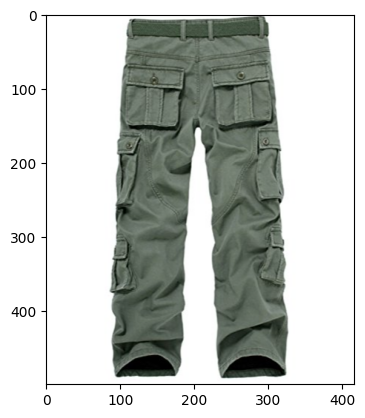

In [94]:
recommended_products = recommend_top_k_products_based_on_link_scores(graph_loaded, 0, loaded_model)

-----------------------------------------------------------------------
original product:


AttributeError: 'NoneType' object has no attribute 'shape'

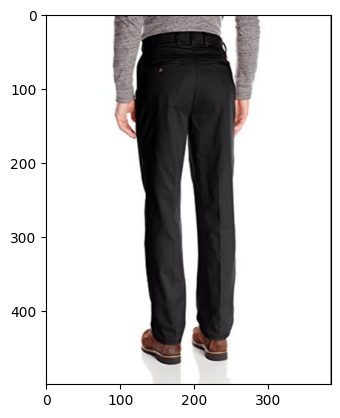

In [92]:
# Example usage:
# Assuming `graph` is your existing graph, `node_id` is the ID of the node to get recommendations for,
# and `model` is your trained GraphSAGE model.
node_id = 5000  # Example node ID
recommended_products = recommend_top_k_products_based_on_link_scores(graph_loaded, node_id, loaded_model)
print("Recommended Product IDs:", recommended_products)

-----------------------------------------------------------------------
original product:


AttributeError: 'NoneType' object has no attribute 'shape'

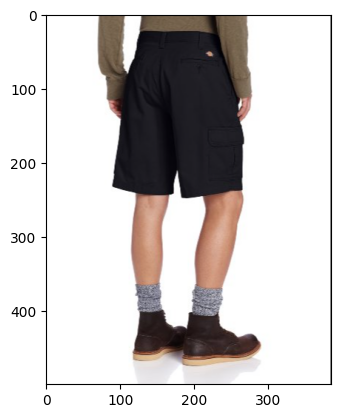

In [93]:
# Example usage:
# Assuming `graph` is your existing graph, `node_id` is the ID of the node to get recommendations for,
# and `model` is your trained GraphSAGE model.
node_id = 20  # Example node ID
recommended_products = recommend_top_k_products_based_on_link_scores(graph_loaded, node_id, loaded_model)
print("Recommended Product IDs:", recommended_products)

In [45]:
# def get_top_k(graph, model, k=6):
#     """
#     Recommends top K products for a given node based on link prediction scores using a trained GraphSAGE model.

#     Parameters:
#     - graph: The DGL graph.
#     - node_id: The ID of the node for which recommendations are to be made.
#     - model: The trained GraphSAGE model.
#     - k: Number of top products to recommend (default is 5).

#     Returns:
#     - List of recommended product node IDs.
#     """
    
#     # Compute node embeddings for the entire graph
#     model.eval()
#     with torch.no_grad():
#         node_embeddings = model(graph, graph.ndata['feat'])
#     link_scores = []
#     for other_node_id in range(graph.number_of_nodes()):
#         score = torch.dot(node_embeddings[0], node_embeddings[other_node_id]).item()
#         link_scores.append((other_node_id, score))
#     link_scores.sort(key=lambda x: x[1], reverse=True)
#     top_k_nodes = [node_id for node_id in link_scores[:k]]
#     return top_k_nodes
#     recommendations = []
#     for i in tqdm(list(graph_loaded.nodes())):
#         node_embedding = node_embeddings[i]
#         # Calculate link prediction scores for the given node with all other nodes
        
        
        
#         # Sort the scores in descending order and get the top K
#         link_scores.sort(key=lambda x: x[1], reverse=True)
#         top_k_nodes = [node_id for node_id in link_scores[:k]]
#         recommendations.append(top_k_nodes)
#     return pd.DataFrame({"node_id":list(graph_loaded.nodes()),'receommendations':recommendations})

In [46]:
def get_recall_at_k(k,graph,model):
    true_val = edges.groupby('asin').also_buy.apply(lambda x: list(x))
    true_val.index.name = 'node_id'
    true_val = true_val.reset_index()
    
    scores_edges['recall'] = scores_edges.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations'][:2000]))/len(x['also_buy']) ,axis=1)
    return scores_edges.recall.mean()

In [49]:
%%time
scores_test = get_recommendation_from_graph(test_g,model,k=100)

100%|██████████| 10867/10867 [00:01<00:00, 6030.78it/s]

CPU times: total: 375 ms
Wall time: 1.87 s


In [ ]:
scores_edges = pd.merge(true_val , scores, on='node_id')
scores_edges

,node_id,also_buy,recommendations
0,1,[16996],"[29941, 10324, 8179, 4539, 25452, 3955, 23666,..."
1,2,"[13453, 15168, 9781, 27959, 4761, 11451, 1535,...","[29941, 10324, 25450, 3324, 268, 3261, 27895, ..."
2,5,"[29452, 29453, 29454, 29721, 7279, 1]","[10324, 29941, 8179, 4539, 3495, 3955, 25452, ..."
3,6,"[1300, 1258, 1593, 1900, 3560]","[29418, 6614, 30555, 28410, 28472, 26221, 1297..."
4,8,"[844, 2185, 25547, 24928, 15703, 171, 1753, 50...","[22956, 19555, 12761, 13909, 12180, 272, 30097..."
...,...,...,...
18772,30654,"[24809, 29837, 14227, 22548]","[19555, 12761, 22956, 13909, 28550, 272, 12979..."
18773,30655,"[20788, 20395, 21430, 27982, 24670, 21372]","[10324, 29941, 28677, 29661, 3495, 21123, 1810..."
18774,30656,"[27239, 25903, 26969, 27241, 29324]","[10324, 29941, 3495, 28677, 29661, 21123, 1810..."
18775,30658,"[24538, 22772, 18727, 22782]","[10324, 29941, 4539, 2674, 8179, 10377, 10712,..."


In [ ]:
scores_edges['recall'] = scores_edges.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations'][:2000]))/len(x['also_buy']) ,axis=1)
scores_edges.recall.mean()

0.2953702555992499

In [48]:
# Example usage:
# Assuming `graph` is your existing graph, `node_id` is the ID of the node to get recommendations for,
# and `model` is your trained GraphSAGE model.
node_id = 300  # Example node ID
recommended_products = recommend_top_k_products_based_on_link_scores(graph_loaded, node_id, loaded_model)
print("Recommended Product IDs:", recommended_products)

RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cpu and parameter tensor at cuda:0

-----------------------------------------------------------------------
original product:
Recommended Product IDs: [(22956, 7.284826278686523), (19555, 6.097294330596924), (13909, 6.009315490722656), (12761, 5.507333755493164), (12180, 5.322539329528809), (272, 5.276097297668457)]


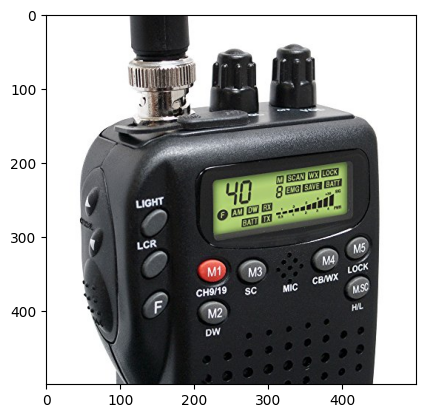

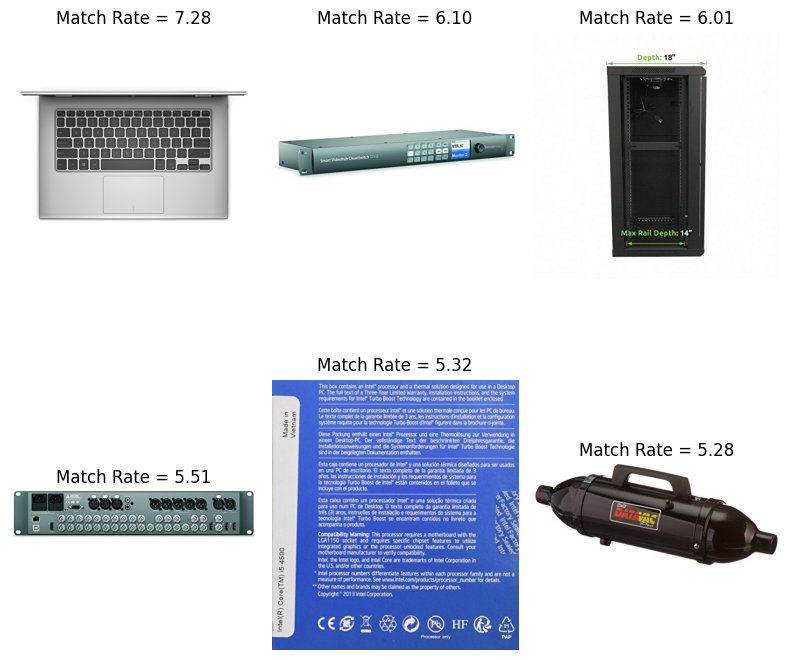

In [ ]:
# Example usage:
# Assuming `graph` is your existing graph, `node_id` is the ID of the node to get recommendations for,
# and `model` is your trained GraphSAGE model.
node_id = 40  # Example node ID
recommended_products = recommend_top_k_products_based_on_link_scores(g, node_id, model)
print("Recommended Product IDs:", recommended_products)

In [ ]:
def compute_link_scores(graph, model, node_pairs=None):
    """
    Computes link prediction scores for node pairs using a trained GraphSAGE model.

    Parameters:
    - graph: The DGL graph.
    - model: The trained GraphSAGE model.
    - node_pairs: A list of tuples, where each tuple represents a pair of node IDs.
                  If None, scores will be computed for all pairs of nodes in the graph.

    Returns:
    - Dictionary where keys are node pairs (tuples) and values are the link scores.
    """
    
    # Compute node embeddings for the entire graph
    model.eval()
    with torch.no_grad():
        node_embeddings = model(graph, graph.ndata['feat'])
    
    # If no specific node pairs are provided, compute scores for all pairs
    if node_pairs is None:
        node_pairs = [(i, j) for i in range(graph.number_of_nodes()) for j in range(i+1, graph.number_of_nodes())]
    
    # Calculate link prediction scores
    link_scores = {}
    for u, v in node_pairs:
        # Compute score using dot product (you can use other scoring mechanisms like cosine similarity)
        score = torch.dot(node_embeddings[u], node_embeddings[v]).item()
        link_scores[(u, v)] = score
    
    return link_scores

# Example usage:
# Assuming `graph` is your existing graph and `model` is your trained GraphSAGE model.
# Compute link scores for all pairs of nodes
# link_scores = compute_link_scores(g, model)

# Optionally, compute link scores for specific pairs of nodes
specific_node_pairs = [(0, 1), (2, 3), (4, 5)]
specific_link_scores = compute_link_scores(g, model, specific_node_pairs)

# print("All Link Scores:", link_scores)
print("Specific Link Scores:", specific_link_scores)

Specific Link Scores: {(0, 1): 18.823564529418945, (2, 3): 1.468723177909851, (4, 5): 1.5798454284667969}


In [ ]:
def recommend_top_k_unlinked_products(graph, node_id, model, k=5):
    """
    Recommends top K products that are not currently linked to the given node using link prediction scores.

    Parameters:
    - graph: The DGL graph.
    - node_id: The ID of the node for which recommendations are to be made.
    - model: The trained GraphSAGE model.
    - k: Number of top products to recommend (default is 5).

    Returns:
    - List of recommended product node IDs.
    """
    
    # Compute node embeddings for the entire graph
    model.eval()
    with torch.no_grad():
        node_embeddings = model(graph, graph.ndata['feat'])
    
    # Extract the embedding of the given node
    node_embedding = node_embeddings[node_id]
    
    # Get the current neighbors of the node (i.e., products that are already bought)
    existing_edges = set(graph.successors(node_id).tolist())
    existing_edges.add(node_id)  # Exclude the node itself from being recommended
    
    # Calculate link prediction scores for the given node with all other unlinked nodes
    link_scores = []
    for other_node_id in range(graph.number_of_nodes()):
        # if other_node_id not in existing_edges:
        score = torch.dot(node_embedding, node_embeddings[other_node_id]).item()
        link_scores.append((other_node_id, score))
    
    # Sort the scores in descending order and get the top K
    link_scores.sort(key=lambda x: x[1], reverse=True)
    top_k_nodes = [node_id for node_id, score in link_scores[:k]]
    
    return (top_k_nodes,link_scores,node_embeddings)

# Example usage:
# Assuming `graph` is your existing graph, `node_id` is the ID of the node to get recommendations for,
# and `model` is your trained GraphSAGE model.
node_id = 0  # Example node ID
top_k_nodes,link_scores,node_embeddings = recommend_top_k_unlinked_products(g, node_id, model, k=5)
print("Recommended Product IDs:", top_k_nodes)

Recommended Product IDs: [650, 280, 528, 529, 1027]


In [ ]:
link_scores = []
for other_node_id in range(g.number_of_nodes()):
    # if other_node_id not in existing_edges:
    score = torch.dot(node_embeddings[842], node_embeddings[other_node_id]).item()
    link_scores.append((other_node_id, score))
link_scores.sort(key=lambda x: x[1], reverse=True)
top_k_nodes = [node_id for node_id, score in link_scores[:60]]
862 in top_k_nodes

False

In [ ]:
scores = torch.cat([pos_score, neg_score]).numpy()
labels = torch.cat(
    [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()

In [ ]:
scores

array([ 4.2493530e+01,  6.3516968e+02,  7.9914673e+01, ...,
       -4.7658050e-01, -4.2613826e+00,  1.3117288e+02], dtype=float32)

In [ ]:
labels

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [ ]:
# Function to make predictions
def predict(model, graph):
    model.eval()
    with torch.no_grad():
        output = model(graph, graph.ndata['feat'].float())
    return output
    
        # print(output)
        # return torch.argmax(output, dim=1)

In [ ]:
output = predict(model,train_g)

In [ ]:
output.shape

torch.Size([2283, 16])

In [ ]:
new_node_id = train_g.number_of_nodes()

In [ ]:
new_node_embedding = output[0]

In [ ]:
train_g.edge_subgraph

<bound method edge_subgraph of Graph(num_nodes=2283, num_edges=3987,
      ndata_schemes={'feat': Scheme(shape=(2170,), dtype=torch.float32)}
      edata_schemes={})>

In [ ]:
# Calculate scores for all product nodes based on similarity (e.g., cosine similarity)
product_embeddings = output[:-1]  # Assuming all nodes except the last one are products
scores = F.cosine_similarity(new_node_embedding.unsqueeze(0), product_embeddings)

# Get the top K product IDs based on the scores
top_k_indices = torch.topk(scores, 5).indices.tolist()

In [ ]:
def recommend_top_k_products_for_node(graph, node_id, model, k=5):
    """
    Recommends top K products for a given node using a trained GraphSAGE model.

    Parameters:
    - graph: The DGL graph.
    - node_id: The ID of the node for which recommendations are to be made.
    - model: The trained GraphSAGE model.
    - k: Number of top products to recommend (default is 5).

    Returns:
    - List of recommended product node IDs.
    """
    
    # Compute node embeddings for the entire graph
    model.eval()
    with torch.no_grad():
        node_embeddings = model(graph, graph.ndata['feat'])
    return node_embeddings
    # Extract the embedding of the given node
    node_embedding = node_embeddings[node_id]
    
    # Calculate scores for all product nodes based on similarity (e.g., cosine similarity)
    scores = F.cosine_similarity(node_embedding.unsqueeze(0), node_embeddings)
    
    # Mask the score of the given node to avoid recommending the node itself
    scores[node_id] = float('-inf')
    
    # Get the top K product IDs based on the scores
    top_k_indices = torch.topk(scores, k).indices.tolist()
    
    return top_k_indices

# Example usage:
# Assuming `graph` is your existing graph, `node_id` is the ID of the node to get recommendations for,
# and `model` is your trained GraphSAGE model.
node_id = 0  # Example node ID
recommended_products = recommend_top_k_products_for_node(train_g, node_id, model, k=5)
print("Recommended Product IDs:", recommended_products)

Recommended Product IDs: tensor([[-0.6300, -2.7456, -0.2526,  ...,  0.6590,  1.4635,  2.0644],
        [-0.7898, -1.7645, -2.0017,  ...,  0.7580,  1.3173,  0.9929],
        [-0.7478,  1.0193, -5.6654,  ...,  1.0686,  4.1647,  2.9371],
        ...,
        [-3.0009, -5.8526, -4.6380,  ...,  0.2716,  3.2869,  3.7501],
        [ 0.5255,  0.6251,  0.7182,  ..., -0.2606,  0.3065,  0.1514],
        [ 0.5255,  0.6251,  0.7182,  ..., -0.2606,  0.3065,  0.1514]])


In [ ]:
recommended_products[0]

tensor([-0.6300, -2.7456, -0.2526,  1.3935, -2.6034,  1.4873, -2.1911,  2.5289,
         0.6673, -0.4867,  0.3065,  0.3598, -0.2743,  0.6590,  1.4635,  2.0644])

In [ ]:
nodes.loc[111].title

'Celestron Erect Image Prism for Refractor and Schmidt Cassegrain'

In [ ]:
output.shape

torch.Size([2283, 16])

In [ ]:
torch.arg(output, dim=1)

AttributeError: module 'torch' has no attribute 'arg'

In [ ]:
text_df = nodes[['title','niche']]
# text_df.asin = text_df.asin.apply(lambda x: asin_map[x])
# text_df = text_df.drop_duplicates('asin').reset_index(drop=True)
text_df = text_df.sort_index().reset_index()
print('nodes',nodes.shape)

#TF-IDF Vectorizer for Title Text Feature

corpus = list(text_df.title)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
X.toarray()

nodes (82, 20)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.24191687, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
img_feature = []
for i in nodes.asin:
    img_feature.append(extract_vectors(f'./processed/images/{i}/1.jpg'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

In [ ]:
X.toarray().shape

(82, 704)

In [ ]:
np.hstack((X.toarray(),np.array(img_feature))).shape

(82, 2752)

In [ ]:
np.array(img_feature).shape

(82, 2048)

In [ ]:
df_full_explode = df_full.copy()
df_full_explode = df_full_explode.explode('also_buy')
# df_full_explode = df_full_explode[(df_full_explode.also_buy.isin(df_full.asin)) | (df_full_explode.also_buy.isna()) ]
df_full_explode.also_buy = np.where(df_full_explode.also_buy.isin(final_list),df_full_explode.also_buy,np.nan)
df_full_explode = df_full_explode.drop_duplicates(['asin','also_buy'])
df_full_explode.shape

(265278, 20)

In [ ]:
sample_df = df_full_explode[~df_full_explode['also_buy'].isna()].head(100)

In [ ]:

edges = sample_df[['asin', 'also_buy']].drop_duplicates(['asin', 'also_buy'])
all_nodes = list(edges.asin) + list(edges.also_buy)
all_nodes = list(set(all_nodes))
#Map String ASINs (IDs) to Int IDs
asin_map_dict = pd.Series(all_nodes).reset_index(drop=True).to_dict()
asin_map = {v: k for k, v in asin_map_dict.items()}

edges['asin'] = edges.asin.apply(lambda x: asin_map[x])
edges['also_buy'] = edges.also_buy.apply(lambda x: asin_map[x])
edges = edges.sort_values(['asin'])
edges = edges.reset_index(drop=True)
# all_nodes = list(edges.asin) + list(edges.also_buy)
# all_nodes = list(set(all_nodes))
edges.shape


(100, 2)

In [ ]:
len(all_nodes)

109

In [ ]:
nodes = df_full[df_full.asin.isin(all_nodes)]
nodes['asin_mapped'] = nodes.asin.apply(lambda x: asin_map[x])
nodes = nodes.set_index('asin_mapped').sort_index()
nodes.shape

(109, 20)

In [ ]:
#Text Manipulations
text_df = nodes[['title','niche']]
# text_df.asin = text_df.asin.apply(lambda x: asin_map[x])
# text_df = text_df.drop_duplicates('asin').reset_index(drop=True)
text_df = text_df.sort_index().reset_index()

In [ ]:
#TF-IDF Vectorizer for Title Text Feature
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = list(text_df.title)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
X.toarray().shape



(109, 604)

In [ ]:
text_df.shape

(109, 3)

In [ ]:
node_features = torch.Tensor(X.toarray())
node_labels = torch.from_numpy(text_df['niche'].astype('category').cat.codes.to_numpy())
edges_src = torch.from_numpy(edges['asin'].to_numpy())
edges_dst = torch.from_numpy(edges['also_buy'].to_numpy())

In [ ]:
node_features.shape

torch.Size([109, 604])

In [ ]:
len(edges_src)

100

In [ ]:


#Build Graph
g = dgl.graph((edges_src, edges_dst))
g.ndata['feat'] = node_features
g.ndata['label'] = node_labels

In [ ]:
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [ ]:
df_full_explode.also_buy.isin(final_list)

index
37        False
37         True
63        False
63         True
63         True
          ...  
786402     True
786402     True
786402     True
786402     True
786402     True
Name: also_buy, Length: 265278, dtype: bool

In [ ]:
df_full['also_buy_new'] = df_full['also_buy'].progress_apply(lambda x: set(df_full.asin).intersection(x))

  0%|          | 122/35511 [00:00<01:34, 374.08it/s]

 73%|███████▎  | 26052/35511 [01:22<00:30, 315.12it/s]


KeyboardInterrupt: 

<Axes: xlabel='also_buy_new'>

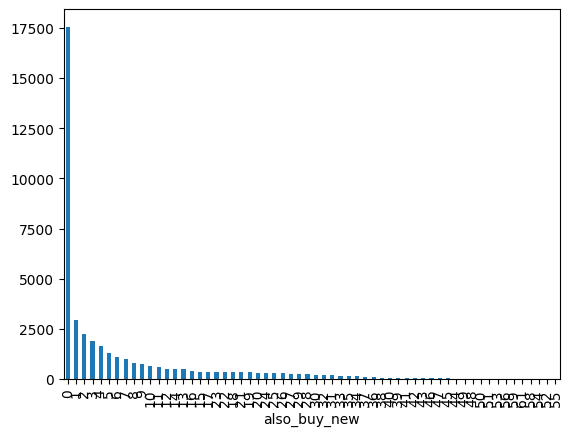

In [ ]:
df_full['also_buy_new'].str.len().value_counts().plot.bar()

In [ ]:
len(final_list)

39250

In [ ]:
df_full_explode.also_buy_new.nunique()

33534

In [ ]:
df_full_explode.asin.nunique()

39250

In [ ]:
edges.to_clipboard()

In [ ]:
df_full_explode.also_buy_new.isna().sum()

17564

In [ ]:
edges

,asin,also_buy_new
0,15691,1797
1,27965,28905
2,27965,24855
3,27965,4407
4,27965,4710
...,...,...
237696,25295,26158
237697,25295,32719
237698,25295,12495
237699,25295,10476


In [ ]:
temp = []
for i in df.also_buy:
    temp+=i

In [ ]:
d

In [ ]:
final_list = list((set(temp) & set(unique_id)))

In [ ]:
df[df.asin=='B00EB179ZI']

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
index,,,,,,,,,,,,,,,,,,,
406044,"[Electronics, GPS, Finders & Accessories, GPS ...",,[Replacement part for Pioneer Power w/Speaker ...,,Xtenzi Power Cord Harness speaker Plug For Pio...,"[B005EVDRZA, B004BBNBM8, B004C4U6RM, B06WLPYN9...",,Xtenzi,[Xtenzi Brand Replacement indash radio Replace...,['>#47 in Electronics > Accessories & Supplies...,[],All Electronics,"class=""a-bordered a-horizontal-stripes a-spa...","August 3, 2013",$2.00,B00EB179ZI,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}


In [ ]:
df = df[df.asin.isin(final_list)]

In [ ]:
len(final_list)

22565

In [ ]:
df['main_cat'].value_counts().to_frame()

,count
main_cat,
Computers,8712
All Electronics,5640
Home Audio & Theater,3073
Cell Phones & Accessories,2914
Camera & Photo,2772


In [ ]:
df['also_buy_new'] = df['also_buy'].apply(lambda x: set(df.asin).intersection(x))

In [ ]:
df['also_buy_new'].str.len().describe()

In [ ]:
df.also_buy

index
7         [B01NAJ3KQB, B00WYSPT0C, B00AF40U5G, B00OFVNM4...
37                                 [B06VTZK822, B00OSI6O7S]
38                                             [B000BUQOGI]
57        [B00E9IKYKK, 1400699169, B00E9ISXPS, B00ZOONDP...
63        [B00940BV1Y, B00RRFMVEE, B0032UP32K, B01MYQWLT...
                                ...                        
786421                 [B002Q907EW, B00HSF65MC, B009VCZ4V8]
786423    [B00IVPU786, B01DOB6Y5Q, B010Q57T02, B01M592J9...
786424                             [B01HJCN55I, B01D6IEG6Q]
786433                                         [B01M096I7Q]
786444                                         [B00Z7SAZXC]
Name: also_buy, Length: 66217, dtype: object

In [ ]:
df[df['asin']=='B00OSI6O7S']

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
index,,,,,,,,,,,,,,,,,,,
556752,"[Electronics, Accessories & Supplies, Audio & ...",,[],,Clikr-5 Time Warner Cable Remote Control Ur5u-...,"[B06VTZK822, B077Y8QWRQ, 0511189877, B00KUL8O0...",,Time Warner Cable,[],"['>#1,585 in Electronics > Accessories & Suppl...",[],Home Audio & Theater,"class=""a-bordered a-horizontal-stripes a-spa...","October 22, 2014",$2.00,B00OSI6O7S,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}


In [ ]:
df.asin

index
7         0101635370
37        0511189877
38        0528013475
57        0594450268
63        0594296420
             ...    
786421    B01HJDXFQQ
786423    B01HJDNL60
786424    B01HJCN5GC
786433    B01HJFRHYA
786444    B01HJH42KU
Name: asin, Length: 66217, dtype: object

In [ ]:
asin_map_dict = pd.Series(edges.asin.append(edges.also_bought).unique()).reset_index(drop=True).to_dict()
asin_map = {v: k for k, v in asin_map_dict.items()}

AttributeError: 'Series' object has no attribute 'append'

In [ ]:
# Load and preprocess image
img_path = './Logo.png'
features = extract_vectors(img_path)
print("Shape of extracted features:", features.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Shape of extracted features: (2048,)


In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
x = base_model.layers[-2].output 
faster_rcnn_model = Model(inputs=base_model.input, outputs=x)


In [ ]:
faster_rcnn_model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


array([[0.46364686, 0.48424578, 0.06289104, ..., 0.16605212, 0.0654472 ,
        0.5422633 ]], dtype=float32)

In [ ]:
features

array([0.46364686, 0.48424578, 0.06289104, ..., 0.16605212, 0.0654472 ,
       0.5422633 ], dtype=float32)

In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, None, None, 3)     │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, None, None, 64)    │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, None, None, 64)    │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, None, None, 64)    │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, None, None, 64)    │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, None, None, 64)    │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, None, None, 64)    │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, None, None, 64)    │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, None, None, 64)    │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, None, None, 64)    │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, None, None, 64)    │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, None, None, 64)    │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, None, None, 256)   │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, None, None, 256)   │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
base_model.input

<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=None, name=keras_tensor>

In [ ]:
# Load pre-trained ResNet50 model without top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(None, None, 3))

# Define Faster R-CNN architecture on top of ResNet50 backbone
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Global Average Pooling to reduce spatial dimensions
faster_rcnn_model = Model(inputs=base_model.input, outputs=x)




# Load and preprocess image
img_path = './Logo.png'
img = keras_image.load_img(img_path, target_size=(224, 224))
img_array = keras_image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Extract features using Faster R-CNN model
features = faster_rcnn_model.predict(img_array)
features = features.flatten()
print("Shape of extracted features:", features.shape)

ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 224, 3), dtype=float32). Expected shape (None, None, None, 3), but input has incompatible shape (32, 224, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(32, 224, 3), dtype=float32)
  • training=False
  • mask=None

In [ ]:
# Load and preprocess image
img_path = './Logo.png'
img = keras_image.load_img(img_path, target_size=(224, 224))
img_array = keras_image.img_to_array(img)


In [ ]:
img_array.shape

(224, 224, 3)

In [ ]:
img_array = np.expand_dims(img_array, axis=0)
img_array.shape

(1, 224, 224, 3)

In [ ]:
img_array = preprocess_input(img_array)
img_array.shape

(1, 224, 224, 3)